# Introduction

In a prior notebook, documents were partitioned by assigning them to the domain with the highest Dice similarity of their term and structure occurrences. Here, we'll assess whether the observed modularity of the partitions is greater than expected by chance. Modularity will be measured by the ratio of dispersion between partitions to dispersion within partitions.

# Load the data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append("..")
import utilities
from style import style

In [2]:
framework = "data-driven" 
version = 190325 # Document-term matrix version
suffix = "" # Suffix for term lists
clf = "_nn" # Suffix for data-driven classifiers
n_iter = 1000 # Iterations for bootstrap and null
dx = [0.34, 0.36, 0.37, 0.31, 0.34, 0.34] # Nudges for plotted means
alpha = 0.001 # Significance level for statistical comparisons

## Brain activation coordinates

In [3]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Document-term matrix

In [4]:
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Domain archetypes

In [5]:
from collections import OrderedDict

In [6]:
lists, circuits = utilities.load_framework(framework, suffix=suffix, clf=clf)

In [7]:
words = sorted(list(set(lists["TOKEN"])))
structures = sorted(list(set(act_bin.columns)))
domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

In [8]:
archetypes = pd.DataFrame(0.0, index=words+structures, columns=domains)
for dom in domains:
    for word in lists.loc[lists["DOMAIN"] == dom, "TOKEN"]:
        archetypes.loc[word, dom] = 1.0
    for struct in structures:
        archetypes.loc[struct, dom] = circuits.loc[struct, dom]
archetypes[archetypes > 0.0] = 1.0
print("Term & Structure N={}, Domain N={}".format(
      archetypes.shape[0], archetypes.shape[1]))

Term & Structure N=190, Domain N=6


## Document structure-term vectors

In [9]:
pmids = dtm_bin.index.intersection(act_bin.index)
len(pmids)

18155

In [10]:
dtm_words = dtm_bin.loc[pmids, words]
act_structs = act_bin.loc[pmids, structures]

In [11]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.head()

,action,anticipation,arousal,articulation,attention,audition,auditory_perception,cognitive,cognitive_control,cognitive_process,...,right_superior_temporal_gyrus_posterior_division,right_supplementary_motor_cortex,right_supracalcarine_cortex,right_supramarginal_gyrus_anterior_division,right_supramarginal_gyrus_posterior_division,right_temporal_fusiform_cortex_anterior_division,right_temporal_fusiform_cortex_posterior_division,right_temporal_occipital_fusiform_cortex,right_temporal_pole,right_thalamus
10022492,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
10022494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,1,1,1,0,0,0,1,0,0
10022496,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
10027301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
10051677,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,1


## Document splits

In [12]:
splits = {}
splits["discovery"] = [int(pmid.strip()) for pmid in open("../data/splits/train.txt")]
splits["replication"] = [int(pmid.strip()) for pmid in open("../data/splits/validation.txt")]
splits["replication"] += [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
for split, pmids in splits.items():
    print("{:12s} N={}".format(split.title(), len(pmids)))

Discovery    N=12708
Replication  N=5447


## Document assignments

In [13]:
doc2dom_df = pd.read_csv("../partition/data/doc2dom_{}{}.csv".format(framework, clf), 
                         header=None, index_col=0)
doc2dom = {int(pmid): str(dom.values[0]) for pmid, dom in doc2dom_df.iterrows()}

In [14]:
dom2docs = {dom: {split: [] for split in ["discovery", "replication"]} for dom in domains}
for doc, dom in doc2dom.items():
    for split, split_pmids in splits.items():
        if doc in splits[split]:
            dom2docs[dom][split].append(doc)

In [15]:
sorted_pmids = {}
for split, split_pmids in splits.items():
    sorted_pmids[split] = []
    for dom in domains:
        sorted_pmids[split] += [pmid for pmid, sys in doc2dom.items() if sys == dom and pmid in split_pmids]
sorted_pmids["discovery"][:5]

[10195224, 10220229, 10355673, 10468630, 10594068]

# Compute document distances

Indexing by min:max will be faster in subsequent computations

In [16]:
from scipy.spatial.distance import cdist

In [17]:
doc_dists = {}
for split in splits.keys():
    ids = sorted_pmids[split]
    doc_dists[split] = cdist(docs.loc[ids], docs.loc[ids], metric="dice")
    doc_dists[split] = pd.DataFrame(doc_dists[split], index=ids, columns=ids)

## Compute domain min and max indices

In [18]:
dom_idx = {}
for split in splits.keys():
    dom_idx[split] = {dom: {"min": 0, "max": 0} for dom in domains}
    for dom in domains:
        dom_pmids = dom2docs[dom][split]
        dom_idx[split][dom]["min"] = sorted_pmids[split].index(dom_pmids[0])
        dom_idx[split][dom]["max"] = sorted_pmids[split].index(dom_pmids[-1]) + 1

# Compute domain modularity

## Observed values

### Distances internal and external to articles in each domain

In [19]:
dists_int, dists_ext = {}, {}
for split, split_pmids in splits.items():
    
    dists_int[split], dists_ext[split] = {}, {}
    for dom in domains:
        
        dom_min, dom_max = dom_idx[split][dom]["min"], dom_idx[split][dom]["max"]
        dom_dists = doc_dists[split].values[:,dom_min:dom_max][dom_min:dom_max,:]
        dists_int[split][dom] = dom_dists
        
        other_dists_lower = doc_dists[split].values[:,dom_min:dom_max][:dom_min,:]
        other_dists_upper = doc_dists[split].values[:,dom_min:dom_max][dom_max:,:]
        other_dists = np.concatenate((other_dists_lower, other_dists_upper))
        dists_ext[split][dom] = other_dists

### Article-level ratio of external to internal distances

In [20]:
df_stat = {}
pmid_list, split_list, dom_list, obs_list  = [], [], [], []

for split, split_pmids in splits.items():
    
    df_stat[split] = pd.DataFrame(index=domains, columns=["OBSERVED"])

    for dom in domains:

        mean_dist_int = np.mean(dists_int[split][dom], axis=0)
        mean_dist_ext = np.mean(dists_ext[split][dom], axis=0)

        df_stat[split].loc[dom, "OBSERVED"] = np.nanmean(mean_dist_ext / mean_dist_int)
        
        obs = mean_dist_ext / mean_dist_int
        pmid_list += dom2docs[dom][split]
        dom_list += [dom] * len(obs)
        split_list += [split] * len(obs)
        obs_list += list(obs)

df_obs = pd.DataFrame({"PMID": pmid_list, "SPLIT": split_list, 
                       "DOMAIN": dom_list, "OBSERVED": obs_list})
df_obs.to_csv("data/mod_obs_{}{}.csv".format(framework, clf))    
df_obs.head()

,PMID,SPLIT,DOMAIN,OBSERVED
0,10195224,discovery,MEMORY,1.323744
1,10220229,discovery,MEMORY,1.046946
2,10355673,discovery,MEMORY,1.078658
3,10468630,discovery,MEMORY,1.142971
4,10594068,discovery,MEMORY,1.004198


In [21]:
for split in splits.keys():
    obs = df_stat[split]["OBSERVED"].mean()
    print("{:28s} {:6.4f}".format(split.title() + " set modularity", obs))

Discovery set modularity     1.1008
Replication set modularity   1.1036


## Null distributions

In [22]:
import os

In [23]:
df_null = {}
for split, split_pmids in splits.items():
    
    print("Processing {} split (N={} documents)".format(split, len(split_pmids)))
    
    n_docs = len(split_pmids)
    file_null = "data/mod_null_{}{}_{}_{}iter.csv".format(framework, clf, split, n_iter)
    if not os.path.isfile(file_null):
        
        df_null[split] = np.empty((len(domains), n_iter))
        for i, dom in enumerate(domains):
            
            print("----- Processing {}".format(dom))
            
            n_dom_docs = dists_int[split][dom].shape[0]
            dist_int_ext = np.concatenate((dists_int[split][dom], dists_ext[split][dom]))
            for n in range(n_iter):
                
                null = np.random.choice(range(n_docs), size=n_docs, replace=False)
                dist_int_ext_null = dist_int_ext[null,:]
                
                mean_dist_int = np.mean(dist_int_ext_null[:n_dom_docs,:], axis=0)
                mean_dist_ext = np.mean(dist_int_ext_null[n_dom_docs:,:], axis=0)
                
                df_null[split][i,n] = np.nanmean(mean_dist_ext / mean_dist_int)

        df_null[split] = pd.DataFrame(df_null[split], index=domains, columns=range(n_iter))
        df_null[split].to_csv(file_null)
        print("")

    else:
        df_null[split] = pd.read_csv(file_null, index_col=0, header=0)

Processing discovery split (N=12708 documents)
Processing replication split (N=5447 documents)


### Interleave splits to facilitate plotting

In [24]:
df_null_interleaved = pd.DataFrame()
null_idx = []
for dom in domains:
    for split in ["discovery", "replication"]:
        df_null_interleaved = df_null_interleaved.append(df_null[split].loc[dom])
        null_idx.append(dom + "_" + split)
df_null_interleaved.index = null_idx
df_null_interleaved.head()

,0,1,10,100,101,102,103,104,105,106,...,990,991,992,993,994,995,996,997,998,999
MEMORY_discovery,0.999804,1.001859,1.003823,1.000766,1.000259,0.998790,1.002327,1.000321,0.989782,1.000225,...,1.000211,1.002958,0.995873,0.998557,0.998570,0.998520,1.000643,0.995142,1.002591,1.000540
MEMORY_replication,0.996697,1.000040,0.997177,1.000172,1.003380,1.004080,1.006237,0.996739,0.998030,0.996563,...,1.003568,0.996028,1.000078,0.996639,0.995189,0.991402,0.999054,0.995172,0.998332,0.995508
REWARD_discovery,0.998860,0.995150,1.003490,1.002830,1.002531,0.998282,0.999829,0.996180,1.003280,0.998213,...,0.996344,0.997376,0.994281,1.001220,1.002322,1.001450,1.006066,1.000441,0.999972,1.001460
REWARD_replication,0.994222,1.006434,0.996412,0.997874,1.001143,1.010375,1.006328,1.000036,1.004884,1.006778,...,0.997902,0.994038,1.002361,0.996311,1.001472,0.996456,1.005092,1.003820,1.007084,1.003313
COGNITION_discovery,1.002751,0.997645,1.000112,0.994068,1.004077,0.996920,1.001037,0.998028,1.000163,0.998903,...,1.000172,0.998874,1.000154,1.000985,0.996442,1.003651,1.004839,0.997628,1.000827,0.998100


## Bootstrap distributions

In [25]:
df_boot = {}
for split, split_pmids in splits.items():
    
    print("Processing {} split (N={} documents)".format(split, len(split_pmids)))

    file_boot = "data/mod_boot_{}{}_{}_{}iter.csv".format(framework, clf, split, n_iter)
    if not os.path.isfile(file_boot):
        
        df_boot[split] = np.empty((len(domains), n_iter))
        for i, dom in enumerate(domains):
            
            print("----- Processing {}".format(dom))
            
            n_docs = dists_int[split][dom].shape[0]
            
            for n in range(n_iter):
                
                boot = np.random.choice(range(n_docs), size=n_docs, replace=True)
            
                mean_dist_int = np.mean(dists_int[split][dom][:,boot], axis=0)
                mean_dist_ext = np.mean(dists_ext[split][dom][:,boot], axis=0)
                
                df_boot[split][i,n] = np.nanmean(mean_dist_ext / mean_dist_int)

        df_boot[split] = pd.DataFrame(df_boot[split], index=domains, columns=range(n_iter))
        df_boot[split].to_csv(file_boot)
        print("")

    else:
        df_boot[split] = pd.read_csv(file_boot, index_col=0, header=0)

Processing discovery split (N=12708 documents)
Processing replication split (N=5447 documents)


# Perform significance testing

In [26]:
from statsmodels.stats import multitest

In [27]:
for split in splits.keys():
    
    pval = []
    for dom in domains:   
        dom_null = df_null[split].loc[dom].values
        dom_obs = float(df_stat[split].loc[dom, "OBSERVED"])
        p = np.sum(dom_null >= dom_obs) / float(n_iter)
        pval.append(p)
        df_stat[split].loc[dom, "P"] = p
    df_stat[split]["FDR"] = multitest.multipletests(pval, method="fdr_bh")[1]
    
    for dom in domains:
        if df_stat[split].loc[dom, "FDR"] < alpha:
            df_stat[split].loc[dom, "STARS"] = "*"
        else:
            df_stat[split].loc[dom, "STARS"] = ""
    df_stat[split] = df_stat[split].loc[domains, ["OBSERVED", "P", "FDR", "STARS"]]
    df_stat[split].to_csv("data/mod_mean_{}{}_{}.csv".format(framework, clf, split))
    
    print("-" * 65 + "\n" + split.upper() + "\n" + "-" * 65)
    print(df_stat[split])
    print("")

-----------------------------------------------------------------
DISCOVERY
-----------------------------------------------------------------
             OBSERVED    P  FDR STARS
MEMORY        1.06866  0.0  0.0     *
REWARD        1.06649  0.0  0.0     *
COGNITION     1.02714  0.0  0.0     *
VISION        1.10487  0.0  0.0     *
MANIPULATION  1.19402  0.0  0.0     *
LANGUAGE      1.14371  0.0  0.0     *

-----------------------------------------------------------------
REPLICATION
-----------------------------------------------------------------
             OBSERVED    P  FDR STARS
MEMORY        1.09097  0.0  0.0     *
REWARD        1.05985  0.0  0.0     *
COGNITION     1.02968  0.0  0.0     *
VISION        1.10755  0.0  0.0     *
MANIPULATION  1.18872  0.0  0.0     *
LANGUAGE       1.1449  0.0  0.0     *



# Plot results

In [28]:
%matplotlib inline

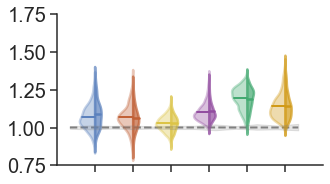

In [29]:
utilities.plot_split_violins(framework, domains, df_obs, df_null_interleaved, df_stat, 
                             style.palettes[framework], metric="mod", dx=dx, 
                             ylim=[0.75,1.75], yticks=[0.75,1,1.25,1.5,1.75], 
                             interval=0.999, alphas=[0], suffix=clf, figsize=(3.7, 2.1))